creates evaluation csv

In [1]:
import pandas as pd

# List of AD identifiers
ad_list = [
    'AD_2018-0289R1_1',
    'AD_2019-0056_1',
    'AD_2019-0173_1',
    'AD_2020-0030_1',
    'AD_2020-0053_1',
    'AD_2020-0118_1',
    'AD_2020-0148_1',
    'AD_2020-0219_1',
    'AD_2020-0250_1',
    'AD_2021-0172_2',
    'AD_2021-0236_1',
    'AD_2021-0256_1',
    'AD_2021-0279_2',
    'AD_2022-0032R1_1',
    'AD_2022-0115_2',
    'AD_2022-0185_1'
]

# Create a DataFrame template
df = pd.DataFrame({
    'AD_Number': ad_list,
    'Models': [''] * len(ad_list),
    'Conditions': [''] * len(ad_list),
    'Affected_Parts': [''] * len(ad_list),
    'Total_Extracted': [''] * len(ad_list),
    'Time_Parsed_sec': [''] * len(ad_list)
})

# Display the DataFrame to the user
#import ace_tools as tools; tools.display_dataframe_to_user(name="AD Extraction Metrics", dataframe=df)

# Optionally, save to CSV
df.to_csv(r'C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\golden_data_llm_without\ad_extraction_metrics_template.csv', index=False)

finds missing model numbers in llm without guidance output

In [20]:
import json
import re

def find_matching_and_missing_models(json_file1_path, json_file2_path):
    """
    Compares aircraft models between two JSON files (specified by paths)
    and identifies matching and missing models.

    Args:
        json_file1_path (str): The path to the first JSON file (ground truth).
        json_file2_path (str): The path to the second JSON file.

    Returns:
        tuple: A tuple containing two lists:
               - matching_models (list): Models found in both files.
               - missing_models (list): Models present in file1 but missing in file2.
    """

    ground_truth_models = set()
    extracted_models_from_file2 = set()

    # Load data from the first JSON file
    try:
        with open(json_file1_path, 'r') as f:
            json_file1_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at {json_file1_path}")
        return [], []
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_file1_path}")
        return [], []

    # Load data from the second JSON file
    try:
        with open(json_file2_path, 'r') as f:
            json_file2_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at {json_file2_path}")
        return [], []
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_file2_path}")
        return [], []

    # Extract models from the first JSON file (ground truth)
    if "applicability_groups" in json_file1_data:
        for group in json_file1_data["applicability_groups"]:
            if "models" in group:
                ground_truth_models.update(group["models"])

    # Extract models from the raw_output of the second JSON file
    if "raw_output" in json_file2_data:
        raw_output = json_file2_data["raw_output"]
        # Regex to find aircraft models (e.g., A318-111, A319, A320)
        model_pattern = re.compile(r'\b[A]\d{3}(?:-\d{3})?\b')
        found_models = model_pattern.findall(raw_output)
        extracted_models_from_file2.update(found_models)

    matching_models = sorted(list(ground_truth_models.intersection(extracted_models_from_file2)))
    missing_models = sorted(list(ground_truth_models.difference(extracted_models_from_file2)))

    return matching_models, missing_models

# Define file paths
file1_path = r"C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_without guidance\golden_data_llm_without\AD_2022-0185_1_c.json"
file2_path = r"C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_without guidance\golden_data_llm_without\AD_2022-0185_1_lng.json"


# Call the function with file paths
matching_models, missing_models = find_matching_and_missing_models(file1_path, file2_path)

print("Matching Models:", matching_models)
print("Missing Models:", missing_models)

Matching Models: []
Missing Models: ['A319-151N', 'A319-153N', 'A319-171N', 'A320-251N', 'A320-252N', 'A320-253N', 'A320-271N', 'A320-272N', 'A320-273N', 'A321-251N', 'A321-251NX', 'A321-252N', 'A321-252NX', 'A321-253N', 'A321-253NX', 'A321-271N', 'A321-271NX', 'A321-272N', 'A321-272NX']


metrics for evaluation

In [1]:
import json
import numpy as np
import os

def analyze_ad_files(file_contents):
    """
    Analyzes a list of AD file contents to extract quantitative metrics.

    Args:
        file_contents (list): A list of dictionaries, where each dictionary
                              represents the content of an AD JSON file.
                              Each dictionary is expected to have 'raw_output'
                              and 'processing_time_seconds' keys.

    Returns:
        dict: A dictionary containing calculated statistics for parsing time
              and raw text character length.
    """
    parsing_times = []
    raw_text_lengths = []

    if not file_contents:
        print("No file contents provided for analysis.")
        return {}

    for file_data in file_contents:
        try:
            # Extract processing time
            if 'processing_time_seconds' in file_data:
                parsing_times.append(file_data['processing_time_seconds'])
            else:
                print(f"Warning: 'processing_time_seconds' not found in a file.")

            # Extract raw text length
            if 'raw_output' in file_data and isinstance(file_data['raw_output'], str):
                raw_text_lengths.append(len(file_data['raw_output']))
            else:
                print(f"Warning: 'raw_output' not found or not a string in a file.")

        except Exception as e:
            print(f"Error processing a file: {e}")

    metrics = {}

    if parsing_times:
        metrics['parsing_time_seconds'] = {
            'mean': np.mean(parsing_times),
            'median': np.median(parsing_times),
            'std_dev': np.std(parsing_times),
            'min': np.min(parsing_times),
            'max': np.max(parsing_times)
        }
    else:
        print("No valid parsing times found to calculate statistics.")

    if raw_text_lengths:
        metrics['raw_text_character_length'] = {
            'mean': np.mean(raw_text_lengths),
            'median': np.median(raw_text_lengths),
            'std_dev': np.std(raw_text_lengths),
            'min': np.min(raw_text_lengths),
            'max': np.max(raw_text_lengths)
        }
    else:
        print("No valid raw text lengths found to calculate statistics.")

    return metrics

# --- Example Usage (replace with your actual file loading logic) ---
# In a real scenario, you would load your 100 JSON files here.
# For demonstration, we'll use the provided snippets.

# Simulate loading file contents from the user's uploaded files
# In your actual environment, you'd iterate through your 100 files
# and parse each JSON into a dictionary.

# To load all your files, you would do something like this (assuming they are in a 'data' folder):
all_file_contents = []
data_folder = r'C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_without guidance\dataset_llm_without' # Replace with the actual path to your files
for filename in os.listdir(data_folder):
    if filename.endswith('.json'):
        filepath = os.path.join(data_folder, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
            all_file_contents.append(data)

# Run the analysis
# For your 100 files, replace `example_file_contents` with `all_file_contents`
results = analyze_ad_files(all_file_contents)
print("\n--- Quantitative Metrics Results ---")
for metric_type, stats in results.items():
    print(f"\n{metric_type.replace('_', ' ').title()}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name.replace('_', ' ').title()}: {value:.3f}")


--- Quantitative Metrics Results ---

Parsing Time Seconds:
  Mean: 9.435
  Median: 8.980
  Std Dev: 2.419
  Min: 6.180
  Max: 26.600

Raw Text Character Length:
  Mean: 1504.720
  Median: 1272.000
  Std Dev: 890.388
  Min: 305.000
  Max: 5065.000


histograms for evaluation


--- Quantitative Metrics Results ---

Parsing Time Seconds:
  Mean: 9.435
  Median: 8.980
  Std Dev: 2.419
  Min: 6.180
  Max: 26.600

Raw Text Character Length:
  Mean: 1504.720
  Median: 1272.000
  Std Dev: 890.388
  Min: 305.000
  Max: 5065.000


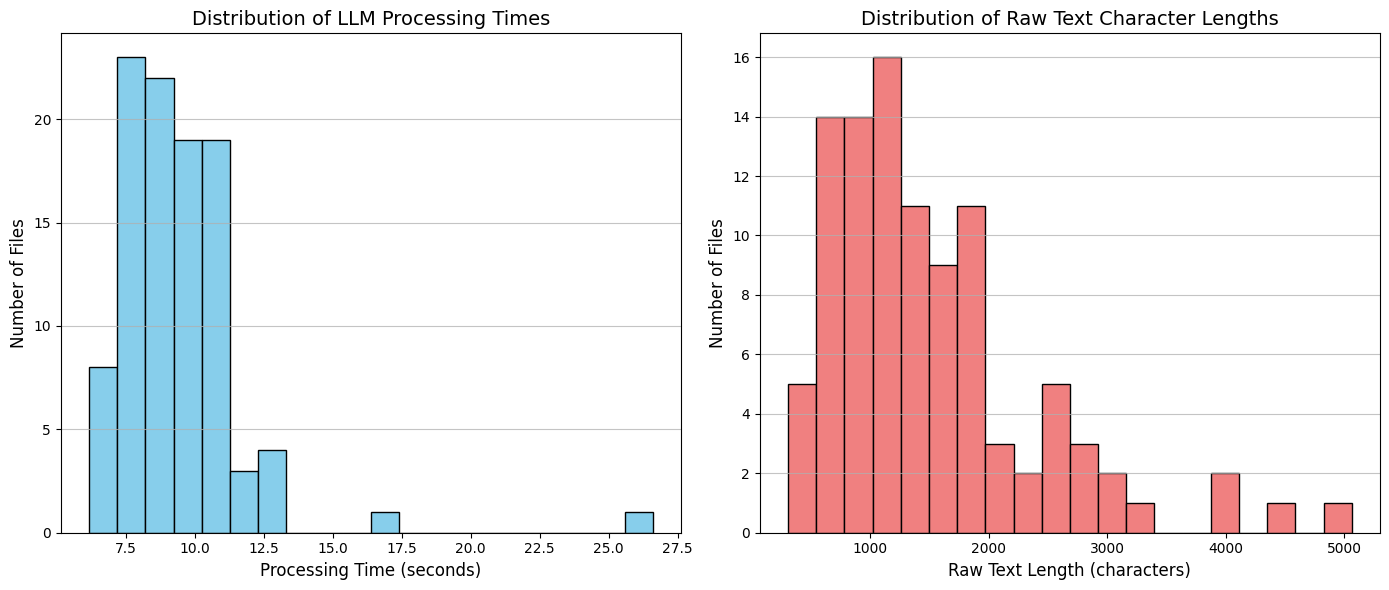

OSError: [Errno 22] Invalid argument: ':\\Users\\zdrop\\OneDrive - TU Wien\\MASTER THESIS\\ADs\\A320\\directives\\sample dataset\\llm_without guidance\\dataset_llm_without\\histograms.png'

<Figure size 640x480 with 0 Axes>

In [5]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt # Import matplotlib for plotting

def analyze_ad_files(file_contents):
    """
    Analyzes a list of AD file contents to extract quantitative metrics.

    Args:
        file_contents (list): A list of dictionaries, where each dictionary
                              represents the content of an AD JSON file.
                              Each dictionary is expected to have 'raw_output'
                              and 'processing_time_seconds' keys.

    Returns:
        tuple: A tuple containing:
               - dict: Calculated statistics for parsing time and raw text character length.
               - list: List of parsing times.
               - list: List of raw text character lengths.
    """
    parsing_times = []
    raw_text_lengths = []

    if not file_contents:
        print("No file contents provided for analysis.")
        return {}, [], []

    for file_data in file_contents:
        try:
            # Extract processing time
            if 'processing_time_seconds' in file_data:
                parsing_times.append(file_data['processing_time_seconds'])
            else:
                print(f"Warning: 'processing_time_seconds' not found in a file.")

            # Extract raw text length
            if 'raw_output' in file_data and isinstance(file_data['raw_output'], str):
                raw_text_lengths.append(len(file_data['raw_output']))
            else:
                print(f"Warning: 'raw_output' not found or not a string in a file.")

        except Exception as e:
            print(f"Error processing a file: {e}")

    metrics = {}

    if parsing_times:
        metrics['parsing_time_seconds'] = {
            'mean': np.mean(parsing_times),
            'median': np.median(parsing_times),
            'std_dev': np.std(parsing_times),
            'min': np.min(parsing_times),
            'max': np.max(parsing_times)
        }
    else:
        print("No valid parsing times found to calculate statistics.")

    if raw_text_lengths:
        metrics['raw_text_character_length'] = {
            'mean': np.mean(raw_text_lengths),
            'median': np.median(raw_text_lengths),
            'std_dev': np.std(raw_text_lengths),
            'min': np.min(raw_text_lengths),
            'max': np.max(raw_text_lengths)
        }
    else:
        print("No valid raw text lengths found to calculate statistics.")

    return metrics, parsing_times, raw_text_lengths

def plot_histograms(parsing_times, raw_text_lengths):
    """
    Generates and displays histograms for processing times and raw text lengths.

    Args:
        parsing_times (list): A list of processing times in seconds.
        raw_text_lengths (list): A list of raw text character lengths.
    """
    if parsing_times and raw_text_lengths:
        plt.figure(figsize=(14, 6), facecolor='white') # Create a figure with a good size for two plots

        # Histogram for Processing Time
        plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
        plt.hist(parsing_times, bins=20, edgecolor='black', color='skyblue') # Use 20 bins for good resolution
        plt.title('Distribution of LLM Processing Times', fontsize=14)
        plt.xlabel('Processing Time (seconds)', fontsize=12)
        plt.ylabel('Number of Files', fontsize=12)
        plt.grid(axis='y', alpha=0.75) # Add a grid for readability

        # Histogram for Raw Text Character Length
        plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
        plt.hist(raw_text_lengths, bins=20, edgecolor='black', color='lightcoral') # Use 20 bins
        plt.title('Distribution of Raw Text Character Lengths', fontsize=14)
        plt.xlabel('Raw Text Length (characters)', fontsize=12)
        plt.ylabel('Number of Files', fontsize=12)
        plt.grid(axis='y', alpha=0.75) # Add a grid for readability
        
        plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
        plt.show() # Display the plots
    else:
        print("\nCannot generate histograms: Not enough data for plotting.")

# --- File Loading Logic (from your provided code) ---
all_file_contents = []
# IMPORTANT: Replace this with the actual path to your dataset
data_folder = r'C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_without guidance\dataset_llm_without'

# Check if the data folder exists to prevent errors
if not os.path.exists(data_folder):
    print(f"Error: The specified data folder does not exist: {data_folder}")
    print("Please ensure the path is correct and accessible.")
else:
    for filename in os.listdir(data_folder):
        if filename.endswith('.json'):
            filepath = os.path.join(data_folder, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    all_file_contents.append(data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {filename}: {e}")
            except Exception as e:
                print(f"An unexpected error occurred while reading {filename}: {e}")

# Run the analysis to get metrics and the lists of data for plotting
metrics_results, parsing_times, raw_text_lengths = analyze_ad_files(all_file_contents)

print("\n--- Quantitative Metrics Results ---")
for metric_type, stats in metrics_results.items():
    print(f"\n{metric_type.replace('_', ' ').title()}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name.replace('_', ' ').title()}: {value:.3f}")

# Call the new plotting function
plot_histograms(parsing_times, raw_text_lengths)

In [7]:
import pandas as pd
import os

def analyze_csv_metrics(filepath):
    """
    Analyzes the provided CSV file to extract statistics for accuracy and error metrics.

    Args:
        filepath (str): The full path to the ad_extraction_metrics_template.csv file.

    Returns:
        dict: A dictionary containing calculated statistics for accuracy metrics
              and error rate metrics.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file was not found at {filepath}")
        return {}
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return {}

    # --- Extraction Accuracy Metrics ---
    # Columns representing accuracy scores
    accuracy_cols = ['AD_number', 'Models', 'Conditions', 'Affected_Parts', 'Total_Accuracy']
    accuracy_stats = {}
    for col in accuracy_cols:
        if col in df.columns:
            accuracy_stats[col] = {
                'mean': df[col].mean(),
                'median': df[col].median(),
                'std_dev': df[col].std(),
                'min': df[col].min(),
                'max': df[col].max()
            }
        else:
            print(f"Warning: Accuracy column '{col}' not found in CSV.")

    # --- Error Rate Metrics ---
    # Columns representing binary error flags
    error_cols = ['error_missing_data', 'error_redundant_information']
    error_stats = {}
    total_entries = len(df)

    for col in error_cols:
        if col in df.columns:
            # For binary (0/1) columns, the mean is the proportion of '1's (i.e., incidence rate)
            error_stats[col] = {
                'incidence_rate': df[col].mean(), # Proportion of files with this error
                'count': df[col].sum() # Total number of files with this error
            }
        else:
            print(f"Warning: Error column '{col}' not found in CSV.")

    return {
        'extraction_accuracy_metrics': accuracy_stats,
        'error_rate_metrics': error_stats
    }

# --- Example Usage ---
# IMPORTANT: Replace this with the actual path to your ad_extraction_metrics_template.csv file
csv_filepath = r'C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_without guidance\golden_data_llm_without\ad_extraction_metrics_template.csv' # Assuming the CSV is in the same directory as your JSONs, or specify its exact path.

# Check if the file exists before attempting to analyze
if not os.path.exists(csv_filepath):
    print(f"Error: The CSV file does not exist at the specified path: {csv_filepath}")
    print("Please ensure the path is correct and accessible.")
else:
    metrics_results = analyze_csv_metrics(csv_filepath)

    if metrics_results:
        print("\n--- Extraction Accuracy Metrics Results ---")
        for metric, stats in metrics_results['extraction_accuracy_metrics'].items():
            print(f"\n{metric.replace('_', ' ').title()} Score:")
            for stat_name, value in stats.items():
                print(f"  {stat_name.replace('_', ' ').title()}: {value:.3f}")

        print("\n--- Error Rate Metrics Results ---")
        for metric, stats in metrics_results['error_rate_metrics'].items():
            print(f"\n{metric.replace('_', ' ').title()}:")
            print(f"  Incidence Rate (Proportion of Files with Error): {stats['incidence_rate']:.3f}")
            print(f"  Count (Number of Files with Error): {int(stats['count'])}")
    else:
        print("No metrics results to display.")




--- Extraction Accuracy Metrics Results ---

Ad Number Score:
  Mean: 0.375
  Median: 0.000
  Std Dev: 0.500
  Min: 0.000
  Max: 1.000

Models Score:
  Mean: 0.438
  Median: 0.000
  Std Dev: 0.512
  Min: 0.000
  Max: 1.000

Conditions Score:
  Mean: 0.875
  Median: 1.000
  Std Dev: 0.289
  Min: 0.000
  Max: 1.000

Affected Parts Score:
  Mean: 0.500
  Median: 0.500
  Std Dev: 0.483
  Min: 0.000
  Max: 1.000

Total Accuracy Score:
  Mean: 2.188
  Median: 2.000
  Std Dev: 0.892
  Min: 1.000
  Max: 4.000

--- Error Rate Metrics Results ---

Error Missing Data:
  Incidence Rate (Proportion of Files with Error): 0.562
  Count (Number of Files with Error): 9

Error Redundant Information:
  Incidence Rate (Proportion of Files with Error): 0.438
  Count (Number of Files with Error): 7
